#Análisis y  clasificación de géneros musicales

Este trabajo se realizó utilizando el dataset de https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification.
El mismo es un dataset con canciones de 30 segundos de 10 géneros musicales (100 por género) y features extraidos de los audios.

Se buscó responder a las siguientes preguntas:



*   ¿Cómo se distribuyen los datos de las canciones a partir de estudiar sus propiedades más importante?
*   ¿Hay géneros más identificables que otros?
*   ¿Como podríamos agrupar las canciones si no supieramos el género musical al que pertenecen?
*   ¿Podemos crear un modelo capaz de predecir el género de una canción?
*   ¿Puede un modelo estimar cómo continúa una canción?



Librerias necesarias:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import IPython.display as ipd #para escuchar los audios
import librosa  #analisis de audios
import librosa.display
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#PCA

In [ ]:
# Clase para realizar componentes principales
from sklearn.decomposition import PCA

# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#para calcular los centroides
from sklearn.neighbors import NearestCentroid

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Music Genre Classification/features_30_sec.csv")
data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#normalizo los datos
min_max_scale = MinMaxScaler()
# Ajustamos el normalizador
min_max_scale.fit(X)
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_norm = min_max_scale.transform(X)

In [ ]:
pca = PCA(n_components=58)
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

In [ ]:
categorias = np.unique(y)
label = []
for i in range(len(y)):
  label.append(np.where(y[i] == categorias)[0][0])
label = np.array(label)
# obtener centroides de las dos componentes
clf = NearestCentroid()
clf.fit(X_pca[:,0:2], y)

NearestCentroid()

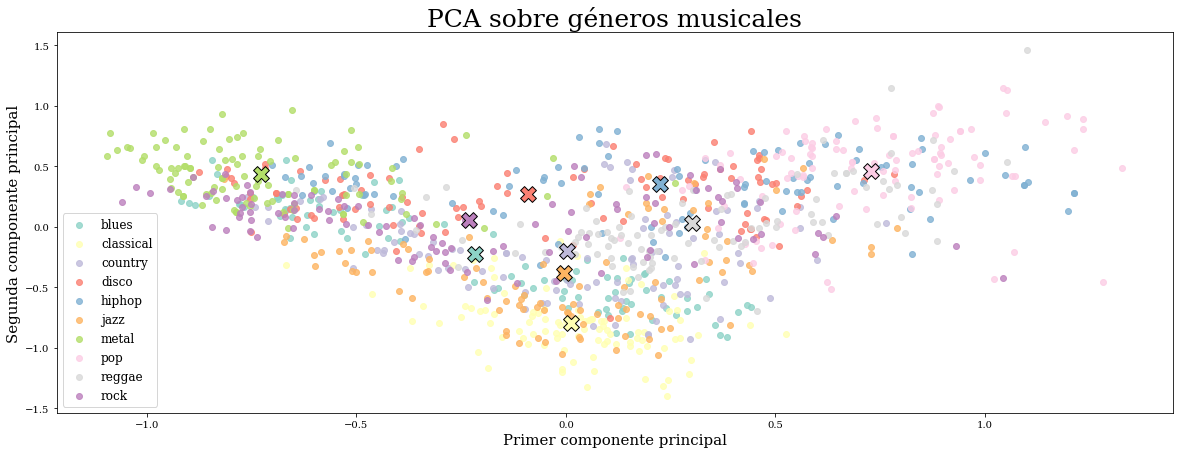

In [ ]:
color = sns.color_palette("Set3")

fig, ax = plt.subplots(figsize = (20, 7))
for i, j in enumerate(categorias):
    ax.scatter(X_pca[y == j, 0], X_pca[y == j, 1],
                label = j, alpha = 0.8, color = color[i])
    ax.scatter(clf.centroids_[i,0],clf.centroids_[i,1], marker="X", s=250, color = color[i], zorder = 5, edgecolor='black')
    ax.legend(fontsize=12)
plt.title('PCA sobre géneros musicales', fontsize = 25)
ax.set_xlabel('Primer componente principal', fontsize = 15)
ax.set_ylabel('Segunda componente principal', fontsize = 15)

fig.savefig('pca.png', dpi=600)

In [ ]:
clf = NearestCentroid()
clf.fit(X_pca, y)  #ahora con todas las componentes
centroides = clf.centroids_
dist_matriz = []
for i, j in enumerate(categorias):
  dist_fila = []
  for k, w in enumerate(categorias):
    dist = np.linalg.norm(centroides[i] - centroides[k])
    dist_fila.append(dist)
  dist_matriz.append(dist_fila)

dist_matriz = np.array(dist_matriz)

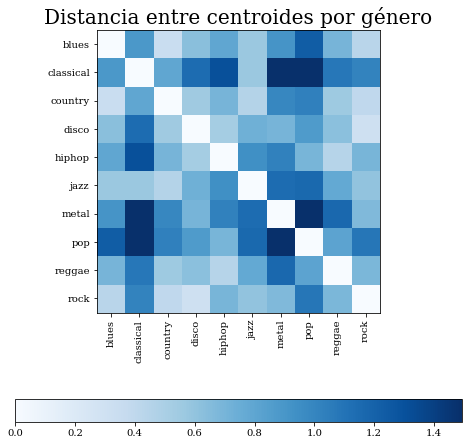

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))  # visualizacion train set
img = ax.imshow(dist_matriz, cmap = "Blues") # graficamos la matriz
y_label_list = len(categorias) # estos son los ticks de los ejes
x_label_list = len(categorias)
ax.set_xticks(np.arange(len(categorias))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(categorias)))
ax.set_yticklabels(categorias) # pongo los ticks de los ejes
ax.set_xticklabels(categorias,rotation = 90)
plt.rcParams['font.family'] = ['Family1', 'serif', 'Family2']
plt.title('Distancia entre centroides por género', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig.savefig("distancia.png", dpi=600)

¿Cuántos datos pierdo al reducir la dimensionalidad?

Text(0.5, 0, 'Cantidad de componentes principales')

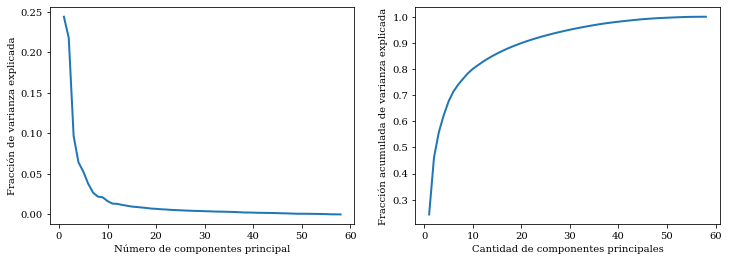

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 2)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componentes principal')

# Calculamos el acumulado con la función cumsum de numpy
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 2)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

#K-Means

In [ ]:
 #importamos el algoritmo de K-means
from sklearn.cluster import KMeans
# importamos el puntaje de silhouette
from sklearn.metrics import silhouette_score

from sklearn.metrics import confusion_matrix

# Clase para realizar componentes principales
from sklearn.decomposition import PCA

In [ ]:
# Creamos una lista para guardar de los coeficientes de silhouette para cada valor de k
silhouette_coefficients = []
sse = [] # acá vamos a guardar el puntaje de la función objetivo (codo)
# Se necesita tener al menos 2 clusters y a los sumo N-1 (con N el numero de muestras) para obtener coeficientes de Silohuette
for k in range(2, 20):
     kkkmeans = KMeans(n_clusters=k)
     kkkmeans.fit(X_norm)
     sse.append(kkkmeans.inertia_)
     score = silhouette_score(X_norm, kkkmeans.labels_)
     silhouette_coefficients.append(score)

Text(0.5, 1.0, 'Método del codo')

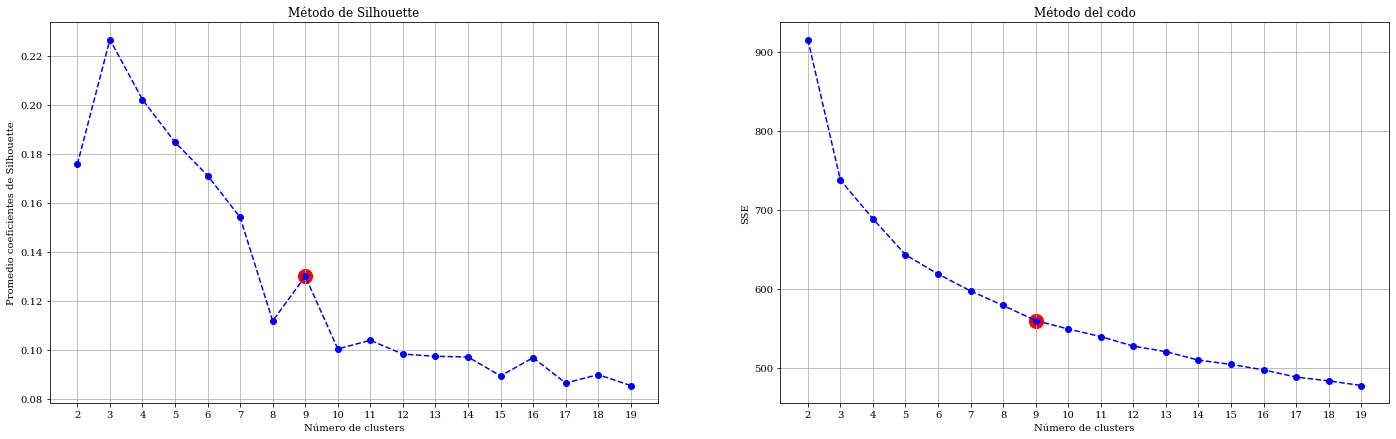

In [ ]:
fig, ax =plt.subplots(1, 2, figsize = (24, 7))

# método de Silhoutette
ax[0].scatter(9, silhouette_coefficients[7], color='red', s=200)
ax[0].plot(range(2, 20), silhouette_coefficients, '--o', c='blue')
ax[0].set_xticks(range(2, 20))
ax[0].set_xlabel("Número de clusters")
ax[0].grid(20)
ax[0].set_ylabel("Promedio coeficientes de Silhouette")
ax[0].set_title('Método de Silhouette')


ax[1].scatter(9, sse[7], color='red', s=200) # agregamos un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax[1].plot(range(2, 20), sse, '--o', c='blue')
ax[1].set_xticks(range(2, 20))
ax[1].set_xlabel("Número de clusters")
ax[1].grid(20)
ax[1].set_ylabel("SSE")
ax[1].set_title('Método del codo')

In [ ]:
# Creación del modelo de PCA con todas las componentes
pca = PCA(n_components = 58)

# Ajuste y transformación de los datos
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

# Guardo las posiciones de los centroids
kmeans = KMeans(n_clusters=10)   #k=10
kmeans.fit(X_pca)
centroids = kmeans.cluster_centers_


In [ ]:
fig, ax = plt.subplots(figsize = (20, 7))
cluster_color = []
for i in range(len(X_pca[:, 0])):
  col = color[kmeans.labels_[i]]
  cluster_color.append(col)
# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_color)
ax.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200, linewidths=1,
            c=color[:10], edgecolors='black')

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')
plt.savefig("kmeans.png", dpi=600)

NameError: ignored

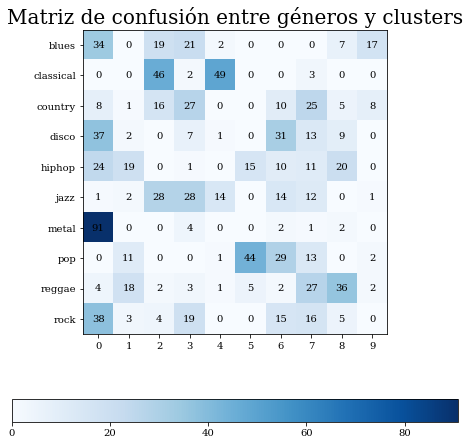

In [ ]:
cm = confusion_matrix(label, kmeans.labels_)

fig, ax = plt.subplots(1,1, figsize=(8,8))
img = ax.imshow(cm,interpolation='none', cmap = "Blues")
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, z, ha='center', va='center')
    y_label_list = categorias
    x_label_list = len(categorias)
    ax.set_xticks(np.arange(len(categorias)))
    ax.set_yticks(np.arange(len(categorias)))
    ax.set_yticklabels(categorias) # pongo los ticks de los ejes
    ax.set_xticklabels(np.arange(len(categorias)))

fig.colorbar(img, orientation="horizontal") # la barra de colores donde no me moleste
plt.rcParams['font.family'] = ['Family1', 'serif', 'Family2']
plt.title('Matriz de confusión entre géneros y clusters', fontsize=20)
plt.savefig("cm_kmeans.png", dpi=600)
plt.show()

# Modelos de clasificacion de los géneros musicales

In [ ]:
# selección de modelos
from sklearn.model_selection import train_test_split
# clasificador: KNN
from sklearn.neighbors import KNeighborsClassifier
# clasificador: support vector classifier
from sklearn.svm import SVC
# clasificador: árbol de decisión
from sklearn.tree import DecisionTreeClassifier
# clasificador: ensemble de árboles (random forest)
from sklearn.ensemble import RandomForestClassifier
# clasificador: red neuronal (perceptron multicapa, 100 capas por defecto, activación por ReLu)
from sklearn.neural_network import MLPClassifier
# performance
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
# normalizador
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Music Genre Classification/features_30_sec.csv")
data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']
min_max_scale = MinMaxScaler()
# Ajustamos el normalizador
min_max_scale.fit(X)
# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_norm = min_max_scale.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3)

In [ ]:
names = ["KNN", "SVM lineal", "SVM RBF", "Árbol de decisión", "Random Forest","Red neuronal"]
classifiers = [
    KNeighborsClassifier(7),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=1, C=10, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=25, n_estimators=100, max_features=10, random_state=10),
    MLPClassifier(alpha=1, max_iter=1000),
    ]

for k in np.arange(len(classifiers)):
  name = names[k]  # nombre
  clf = classifiers[k] # objeto de clasificador
  clf.fit(X_train, y_train) # entreno
  score_test = clf.score(X_test, y_test) # evaluo
  score_training = clf.score(X_train,y_train)
  print(f'Accuracy de {name}: {score_test} en test y de {score_training} en training')


Accuracy de KNN: 0.67 en test y de 0.7542857142857143 en training
Accuracy de SVM lineal: 0.29 en test y de 0.32142857142857145 en training
Accuracy de SVM RBF: 0.7233333333333334 en test y de 1.0 en training
Accuracy de Árbol de decisión: 0.5866666666666667 en test y de 0.6614285714285715 en training
Accuracy de Random Forest: 0.8133333333333334 en test y de 1.0 en training
Accuracy de Red neuronal: 0.6766666666666666 en test y de 0.7642857142857142 en training


Matriz de confusión para Random Forest

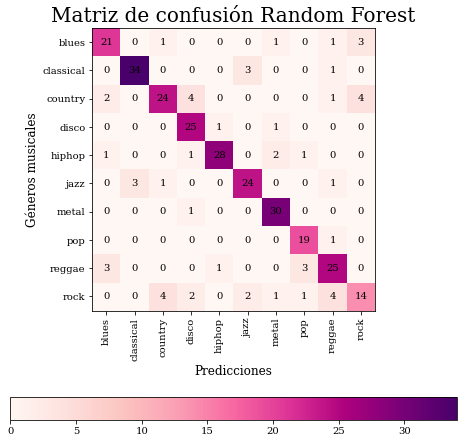

In [ ]:
clf = RandomForestClassifier(max_depth=25, n_estimators=100, max_features=10 ,random_state=10)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

cm = confusion_matrix(y_test, preds)

fig, ax = plt.subplots(1,1, figsize=(8,8))
img = ax.imshow(cm,interpolation='none',cmap='RdPu')
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, z, ha='center', va='center')
    y_label_list = categorias
    x_label_list = len(categorias)
    ax.set_xticks(np.arange(len(categorias)))
    ax.set_yticks(np.arange(len(categorias)))
    ax.set_yticklabels(categorias) # pongo los ticks de los ejes
    ax.set_xticklabels(categorias, rotation = 90)

ax.set_ylabel("Géneros musicales", fontsize=12)
ax.set_xlabel("Predicciones", fontsize=12)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste
plt.rcParams['font.family'] = ['Family1', 'serif', 'Family2']
plt.title('Matriz de confusión Random Forest', fontsize=20)
plt.savefig('cm_randomforest.png', dpi=600)
plt.show()

Celda de código para determinar mejores hiperparámetros

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_norm, y)
print(
    "The best parameters are %s with a score of %0.3f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 10.0, 'gamma': 1.0} with a score of 0.749


#Modelo de regresión sobre los mel-espectrogramas

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [ ]:
ruta = "/content/drive/My Drive/Music Genre Classification/genres_original/"
generos = os.listdir(ruta)
print(len(generos))
matrices_rotadas = []
for genero in generos:
  audios = os.listdir(ruta+genero)
  for audio in audios:
    path = ruta+genero+'/'+audio
    data,sr = librosa.load(path,sr = 22050)
    M = librosa.feature.melspectrogram(y=data, sr=sr) #melspectrograma
    M = M[:,:1290]
    MR = np.transpose(M)
    MR = list(MR.reshape(-1))
    matrices_rotadas.append(MR)
matrices_rotadas = np.array(matrices_rotadas)

10


In [ ]:
from sklearn.utils import shuffle
matrices_rotadas = matrices_rotadas / np.max(matrices_rotadas)
matrices_rotadas = shuffle(matrices_rotadas, random_state=1)  #mezclo el orden de los audios
train = matrices_rotadas[:-5]
test = matrices_rotadas[-5:]
n_pixels = matrices_rotadas.shape[1] # numero de pixeles de lado
X_train = train[:, :(n_pixels + 1) // 2] # mitad superior como features para train
y_train = train[:, n_pixels // 2:] # mitad inferior como etiquetas para train
X_test = test[:,:(n_pixels + 1) // 2] # mitad superior como features para test
y_test = test[:, n_pixels // 2:]# mitad inferior como etiquetas para test

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_test_knn = knn.predict(X_test)

In [ ]:
image_shape = (1290, 128) # forma de la imagen
audios_reconstruidos = []
for i in range(5):
    completed_mel = np.hstack((X_test[i], y_test_knn[i])) # compongo la parte superior con la inferior (original)
    audio_reshape = completed_mel.reshape(image_shape) * np.max(matrices_rotadas)
    audio_reshape = np.transpose(audio_reshape)
    audios_reconstruidos.append(audio_reshape)


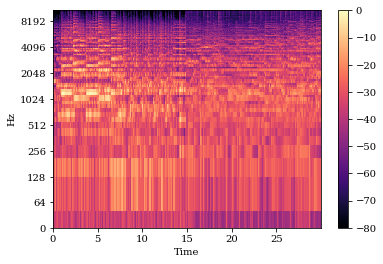

In [ ]:
S_dB = librosa.power_to_db(audios_reconstruidos[1], ref=np.max)
plt.figure()
librosa.display.specshow(S_dB,sr=22050, hop_length = 512, x_axis = 'time', y_axis = 'log')
plt.colorbar();
S2 = librosa.feature.inverse.mel_to_stft(audios_reconstruidos[1])
y2 = librosa.griffinlim(S2)  #audio reconstruido
ipd.Audio(y2,rate=22050)